## TPU  (Tensor Processing Unit-Tenzor İşlem Birimi) üzerinde MNIST veri seti eğitimi<br>ya da GPU kullanarak tf.Keras ve tf.data.Dataset
<table><tr><td><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/keras-tensorflow-tpu300px.png" width="300" alt="Keras+Tensorflow+Cloud TPU"></td></tr></table>


Bu örnek bir Keras modelini kullanarak bir GPU veya TPU kullanarak "MNIST" el yazısı rakamları tanıma modelini eğitiyor. Veriler tf.data.Dataset API kullanılarak işlenmaktedir. Bu eğitim amaçlı sağlanan çok basit bir örnek.
MNIST kadar küçük bir veri setinde olağanüstü TPU performansı beklemeyin. Ama büyük bir veri setinde GPU ile arasında büyük fark oluşacağını görebilirsiniz.

### DETAYLI TPU KULLANIMI ANLATIMI VE FARKLI ÖRNEKLER İÇİN: [Adım Adım Google Colab Ücretsiz TPU Kullanımı](https://medium.com/deep-learning-turkiye/ad%C4%B1m-ad%C4%B1m-google-colab-%C3%BCcretsiz-tpu-kullan%C4%B1m%C4%B1-621dc6e5487d)


<h3><a href="https://cloud.google.com/gpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/gpu-hexagon.png" width="50"></a>  &nbsp;&nbsp; GPU veya TPU kullanarak Eğitim&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

  1. GPU ya da TPU seçeneğini işaretleyin (Runtime > Change runtime type) 
  1. Runtime > Run All (Dikkat: the "Colab-only auth" hücre kullanıcı girişi gerektirir.)

<h3><a href="https://cloud.google.com/ml-engine/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/mlengine-hexagon.png" width="50"></a>  &nbsp;&nbsp;ML Engine Deploy Edin</h3>

1. Bu dizüstü bilgisayarın alt kısmında, sunucusuz, otomatik ölçeklendirilmiş, REST API deneyimi için eğitimli modelinizi ML Engine'e yerleştirebilirsiniz. Bu son kısım için bir GCP projesine ve bir GCS bucket ihtiyacınız olacak.

TPU'lar Google Cloud'da bulunur, optimum performans için, verileri doğrudan Google Cloud Storage'dan (GCS) okurlar.

**KAYNAK: ** [Martin Gorner](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb#scrollTo=hleIN5-pcr0N)

### PARAMETRELER

In [0]:
BATCH_SIZE = 128

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Import EDİLMESİ GEREKENLER

In [0]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.12.0


### TPU Kullanılabilmesi için Colab Kimlik Doğrulama İşlemleri 

In [0]:
# backend Kimliği
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # bu daima Colab’da ayarlanır, GPU varlığına bağlı olarak değer 0 ya da 1’dir.
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
HAS_CTPU_TPU = 'TPU_NAME' in os.environ
HAS_MANUAL_TPU = False
# TPU_NAME ayarlanmamış durumdayken çalışmak için aşağıdaki satırı kaldırın. Lütfen vm adınızı el ile ayarlayın.
# HAS_MANUAL_TPU, MANUAL_VM_NAME = True, 'MY_VM_NAME'
USE_TPU = HAS_COLAB_TPU or HAS_CTPU_TPU or HAS_MANUAL_TPU

# Colab'da Yetkilendirme (küçük uyarı: kimlik doğrulaması olmadan, Colab genel olarak bir GCS bucket verilere erişmede çok yavaş olacaktır).
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()
  
# Ayrıca Colab Auth ürününü TPU'ya yayar, böylece GCS bucket e, hatta özel olanlara bile erişebilir.
if IS_COLAB_BACKEND and HAS_COLAB_TPU:
  with tf.Session('grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])) as sess:    
    with open('/content/adc.json', 'r') as f:
      auth_info = json.load(f) # Kimlik bilgilerini TPU'ya yükleyin.
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)

# TPU’yu bulun.
if IS_COLAB_BACKEND and HAS_COLAB_TPU:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
elif HAS_CTPU_TPU:
  TPU_ADDRESS = os.environ['TPU_NAME']
elif HAS_MANUAL_TPU:
  TPU_ADDRESS = MANUAL_VM_NAME
      
if USE_TPU:
  print('Using TPU:', TPU_ADDRESS)

Using TPU: grpc://10.113.143.202:8470


In [0]:
#@title Görselleştirme Araçları [BURAYI ÇALIŞTIR]
"""
Bu hücre yalnızca görselleştirme ve indirme işlemleri için kullanılan yardımcı fonksiyonları içerir.
Okumayı atlayabilirsiniz.
Burada çok az yararlı Keras / Tensorflow kodu var.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# Veri kümelerinden bir parti çekin. Bu kod çok hoş değil. mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # Herbirinden bir batch almak: 10000 doğrulama verisi, N eğitim verisi
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
  t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
  
  # Birkez çalıştır, bir batch-küme al. Session.run sonuçlar numpy sonuçlar
  with tf.Session() as ses:
    (validation_digits, validation_labels,
     training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # Verisetindeki one-hot encoding
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# cTest için yerel fontlardan rakamlar oluşturun
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# tahminleri ile birlikte bir rakam hanesini görüntülemek için yardımcı
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # kırmızı kötü tahminler
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# Tanınmayan / tanınan duruma göre sıralanmış, birden çok basamaklı satır görüntülemek için yardımcı program.
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: önce tanınmayan
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# Eğitim ve doğrulama eğrilerinin görüntülenmesi için yardımcı program
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # ilk aramada alt noktaları ayarla
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### tf.data.Dataset: dosyaları ayrıştırın ve eğitim ve doğrulama veri kümelerini hazırlayın
Lütfen okuyun: [best practices for building](https://www.tensorflow.org/guide/performance/datasets) 

In [0]:
def read_label(tf_bytestring):
    label = tf.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # Bu küçük veri kümesi RAM'de tamamen önbellekte saklanabilir, TPU için bu kadar küçük bir veri setinden iyi performans almak önemlidir.
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Şimdilik Keras için zorunlu
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder TPU'da önemlidir, küme büyüklüğü sabitlenmelidir
    dataset = dataset.prefetch(10)  # Geçerli olanı çalıştırırken sonraki ükümeleri getir
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # Bu küçük veri kümesi RAM'de tamamen önbellekte saklanabilir, TPU için bu kadar küçük bir veri setinden iyi performans almak önemlidir.
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 doğrulama kümesi, tamamı bir küme içinde
    dataset = dataset.repeat() # Şimdilik Keras için zorunlu
    return dataset

# veri kümelerini başlat
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# TPU için veri setini döndüren bir işleve ihtiyacımız olacak
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Verilere bir göz atalım! 

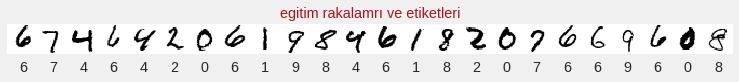

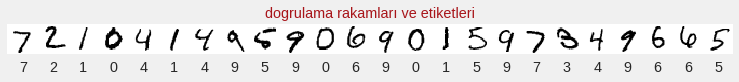

In [0]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "egitim rakalamrı ve etiketleri", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "dogrulama rakamları ve etiketleri", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 Evrişim Katmanı, 2 tam/tüm Bağlantı Katmanı
Çapraz entropi, unutma, softmax veya toplu normalizasyonun ne anlama geldiğinden emin değilseniz, bu kaynaklara göz atabilirsiniz:


*  [Yapay Öğrenme Modelleri Geliştirirken Karşılaşılan Sorunlar & Çözümleri (Part1)](https://www.youtube.com/watch?v=gbzwtZGrkrQ)
*   [Yapay Öğrenme Modelleri Geliştirirken Karşılaşılan Sorunlar & Çözümleri (Part2)](https://www.youtube.com/watch?v=L3NJi7diDmg&t=139s)
* [Derin Öğrenme Uygulamalarında Başarım İyileştirme Yöntemleri (Regularization)](https://medium.com/@necmettin.carkaci/derin-%C3%B6%C4%9Frenme-uygulamalar%C4%B1nda-ba%C5%9Far%C4%B1m-i%CC%87yile%C5%9Ftirme-y%C3%B6ntemleri-regularization-fb521e64c30f)
* [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [0]:
# Bu model 10 epoch % 99.4, bazen % 99.5'e kadar doğruluk sağlar (küme büyüklüğü 32 ile)

l = tf.keras.layers
model = tf.keras.Sequential(
  [
    l.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),

    l.Conv2D(filters=6, kernel_size=3, padding='same', use_bias=False), # küme normundan önce biasa gerek yok
    l.BatchNormalization(scale=False, center=True), # "relu" dan önce küme norm ölçeklemesi gerekmez
    l.Activation('relu'), # küme normundan sonra aktivasyon

    l.Conv2D(filters=12, kernel_size=6, padding='same', use_bias=False, strides=2),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),

    l.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),

    l.Flatten(),
    l.Dense(200, use_bias=False),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),
    l.Dropout(0.5), # Tam bağlantı katmanında unutma/dropout

    l.Dense(10, activation='softmax')
  ])

model.compile(optimizer='adam', # öğrenme oranı sabitlenir LearningRateScheduler
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model katmanlarını ekrana yazdır
model.summary()

# öğrenme hızı azalmasını ayarlama
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 + 0.02 * math.pow(0.5, 1+epoch), verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         54        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         18        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 12)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 12)        36        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 12)        0         
__________

### EĞİTİM VE DOĞRULAMA İŞLEMLERİ

In [0]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 veri (veri setinde)
trained_model = model


# TPU'daki adımları ve kümeleri sayma: tpu.keras_to_tpu_model API, giriş veri kümesinin küme boyutunu çekirdek küme başına boyut olarak kabul eder.
# Cloud TPU'ların 8 çekirdeği bulunduğundan, etkili küme büyüklüğü 8 kat daha fazladır.
# Global bir toplu işlem (çekirdek başına 8 işlem) her işlenişinde, +8 adımını artırır.
# Bu nedenle, küme büyüklüğü ve steps_per_epoch ayarları, TPU eğitimi için olduğu gibi kalabilir.
# Eğitim sadece daha hızlı olacak.
# Uyarı: Bu, Keras / TPU API'nin son sürümünde değişebilir.

if USE_TPU:
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS))
  trained_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
  # Devam eden çalışmalar: Keras / TPU için henüz uygulanmamış veri kümesi nesnesinden doğrudan okuma. Keras / TPU, veri kümesini döndüren bir fonksiyona ihtiyaç duyar.
  history = trained_model.fit(training_input_fn, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                            validation_data=validation_input_fn, validation_steps=1, callbacks=[lr_decay])
else:
  history = trained_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                              validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay])

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.113.143.202:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9287373438149051798)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1007330524970951909)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17840639716337172112)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 985434692605563827)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9155432728133669593)
INFO:tensorflow:*** Available Device: _Device

### Eğitim ve Doğrulama Eğrilerini Görselleştirin

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


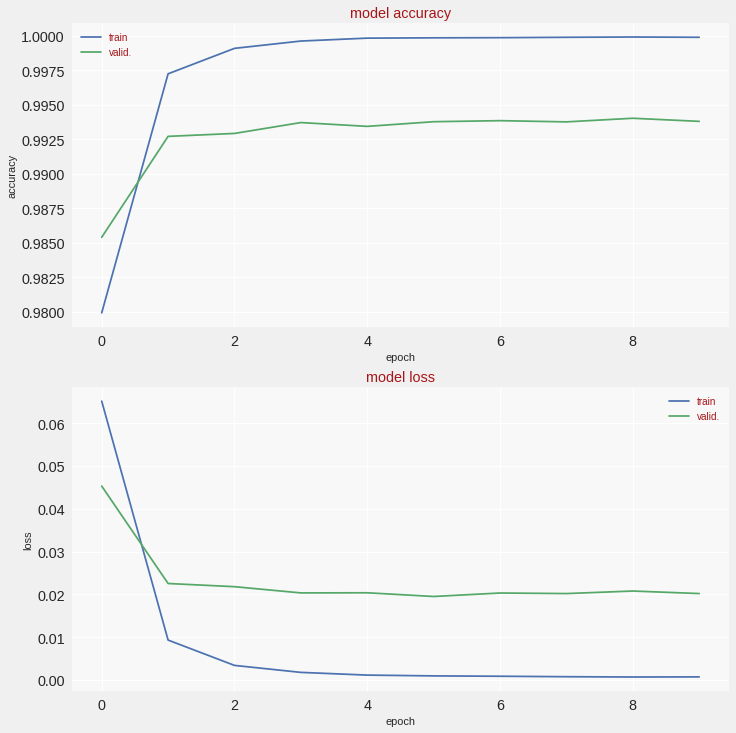

In [0]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Kestirimleri Görselleştirin

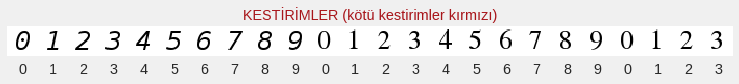

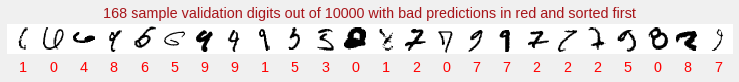

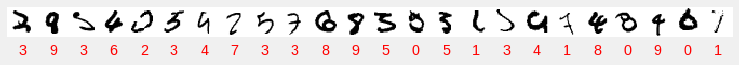

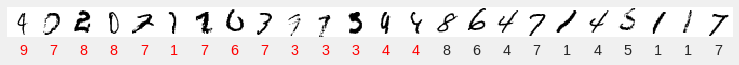

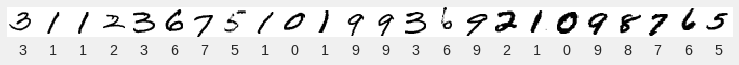

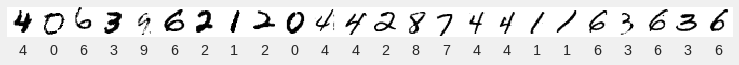

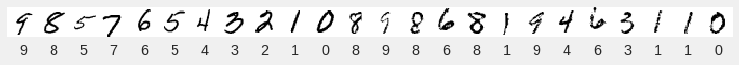

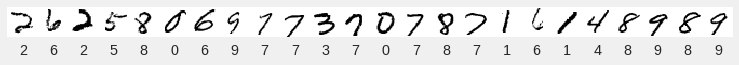

In [0]:
# Yerel fontlardan rakamları tanıyabilir
probabilities = trained_model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "KESTİRİMLER (kötü kestirimler kırmızı)", N)

# doğrulama verisini tanır
probabilities = trained_model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Eğitilmiş modeli ML Engine'e dağıtın
Sunucusuz, otomatik ölçeklendirilmiş, REST API deneyimi için eğitimli modelinizi ML Engine'de üretin.
Bunun için bir GCS bucket ve bir GCP projesine ihtiyacınız olacak.
Kullanılmadığı takdirde ML Engine otomatik ölçeğinde dağıtılan modeller sıfıra gider. Test tamamlandıktan sonra ML Engine ücreti alınmayacaktır.
Google Cloud Storage ücrete tabidir. Bunlardan kaçınmak istiyorsanız, yerleştirmeden sonra bucketi boşaltın. Model dağıtıldığında, bucket artık kullanılmaz.


### Yapılandırma

In [0]:
PROJECT = "" #@param {type:"string"}
BUCKET = "gs://"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "colabmnist" #@param {type:"string"}
MODEL_VERSION = "v0" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### ML Engine'den servis yapmak için modeli dışa aktarın

In [0]:
class ServingInput(tf.keras.layers.Layer):
  # ÖNEMLİ DETAY: "trainable=False"
  def __init__(self, name, dtype, batch_input_shape=None):
    super(ServingInput, self).__init__(trainable=False, name=name, dtype=dtype, batch_input_shape=batch_input_shape)
  def get_config(self):
    return {'batch_input_shape': self._batch_input_shape, 'dtype': self.dtype, 'name': self.name }

  def call(self, inputs):
    # Dağıtılan model, REST API'siyle çağrıldığında, JSON yükü otomatik olarak ayrıştırılır, bir tensöre dönüştürülür ve bu giriş katmanına iletilir.
    # Verileri modelinize göndermeden önce, örneğin JPEG'lerin kodunu çözmek gibi ek dönüştürmeler yapabilirsiniz.
    # Ancak, yalnızca tf.xxxx işlemlerini kullanabilirsiniz.
    return inputs

# Küçük Uyarı: modeli TPU'dan CPU'ya manuel olarak kopyalamalıdır. Bu geçici bir çözümdür.
tf_logging.set_verbosity(tf_logging.INFO)
restored_model = model
restored_model.set_weights(trained_model.get_weights()) # bu ağırlıkları TPU'dan kopyaladı, GPU'da hiçbir şey yapmıyor.
tf_logging.set_verbosity(tf_logging.WARN)

# Serving giriş katmanı ekleyin
serving_model = tf.keras.Sequential()
serving_model.add(ServingInput('serving', tf.float32, (None, 28*28)))
serving_model.add(restored_model)
export_path = tf.contrib.saved_model.save_keras_model(serving_model, os.path.join(BUCKET, 'keras_export'))  # modeli buckete dışa aktarma
export_path = export_path.decode('utf-8')
print("Model exported to: ", export_path)

### Modeli Deploy Etmek
Bu komut satırı arayüzünü kullanır. Aynı şeyi adresindeki ML Engine UI üzerinden de yapabilirsiniz: https://console.cloud.google.com/mlengine/models

In [0]:
# Modeli oluştur
if NEW_MODEL:
  !gcloud ml-engine models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

In [0]:
# Bu modelin bir sürümünü oluşturun (bu çağrıyı engellememek için satırın sonuna --async ekleyebilirsiniz).
# Ek yapılandırma bayrakları kullanılabilir: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions.
# Ayrıca --staging-bucket = ... parametresi sağlayarak yerel olarak depolanan bir modeli dağıtabilirsiniz.
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10

### Deploy Edilen Modeli Test Etme
Modeliniz artık REST API'sı olarak mevcut.
Aramaya çalışalım. Aşağıdaki hücreler "gcloud ml-engine" komut satırı aracını kullanır, ancak REST bitiş noktasına bir JSON yükü gönderebilecek herhangi bir araç çalışır.

In [0]:
# çevrimiçi tahmin bitiş noktasına göndermek için rakamlar hazırlayın
digits = np.concatenate((font_digits, validation_digits[:100-N]))
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits:
    # ML Engine çevrimiçi tahminleri için biçim: satır başına bir JSON nesnesi
    data = json.dumps({"serving_input": digit.tolist()})  # "serving_input" Çünkü ServingInput katmanı "serving" olarak isimlendirildi. Keras "_input" ekler.
    f.write(data+'\n')

In [0]:
# "Gcloud ml-engine" komut satırını kullanarak dağıtılmış modelden (REST API) çevrimiçi tahminler isteyin.
predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

probabilities = np.stack([json.loads(p) for p in predictions[1:]]) # ilk satır girdi katmanının adıdır: bırakın, gerisini çözümleyin.
predictions = np.argmax(probabilities, axis=1)
display_top_unrecognized(digits, predictions, labels, N, 100//N)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


Bu resmi bir Google ürünü değil, eğitim amaçlı verilen örnek koddur.
